# Web App

In this notebook, we explain the different API calls of the web app and code along similar functionnalitites.

In [1]:
import base64
import io
import requests

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

## List of APIs

In [2]:
res = requests.get("http://127.0.0.1:5000/api_list")
res.json()

{'available-apis': [{'api-key': 'cmd: /api_list',
   'description': 'return the list of available commands.'},
  {'api-key': 'cmd: /find_images',
   'description': 'receives a sketch and returns its closest images.'},
  {'api-key': 'cmd: /get_embeddings',
   'description': 'receives a dimension number (2D or 3D) and returns the PCA scattered points of the embeddings'},
  {'api-key': 'cmd: /get_dataset_images',
   'description': 'receives a category name and return 5 random images and sketches of this category.'}]}

## Inference: return closest images of sketch

We send an svg drawing to the web app.

In [47]:
data = {
  "sketch": "<svg width=\"1044.4176025390625\" height=\"638.4090576171875\"><path stroke-width=\"3\" stroke=\"#000000\" fill=\"none\" stroke-linejoin=\"round\" stroke-linecap=\"round\" d=\"M 487.3721218109131 271.2784118652344 C 487.5521218109131 271.2784118652344 487.5512404632568 271.2784118652344 488.28124046325684 271.2784118652344 C 489.01124046325685 271.2784118652344 489.55853538513185 271.2784118652344 491.00853538513184 271.2784118652344 C 492.4585353851318 271.2784118652344 493.37394554138183 271.2784118652344 495.55394554138184 271.2784118652344 C 497.73394554138184 271.2784118652344 499.91759300231934 271.2784118652344 501.91759300231934 271.2784118652344 C 503.91759300231934 271.2784118652344 504.46394554138186 271.2784118652344 505.55394554138184 271.2784118652344 C 506.6439455413818 271.2784118652344 506.64212181091307 271.2784118652344 507.3721218109131 271.2784118652344 C 508.1021218109131 271.2784118652344 508.4602980804443 271.2784118652344 509.19029808044434 271.2784118652344 C 509.92029808044435 271.2784118652344 510.2785353851318 271.2784118652344 511.00853538513184 271.2784118652344 C 511.73853538513185 271.2784118652344 512.2767116546631 271.2784118652344 512.8267116546631 271.2784118652344 C 513.376711654663 271.2784118652344 513.5557692718506 271.2784118652344 513.7357692718506 271.2784118652344 C 513.9157692718505 271.2784118652344 513.7357692718506 271.2784118652344 513.7357692718506 271.2784118652344\"></path></svg>"
}

In [48]:
res = requests.post("http://127.0.0.1:5000/find_images", json=data).json()

It returns the 2 closest images in base 64 bytes with their associated labels and the attention map associated to the sketch.

In [49]:
images_base64 = res['images_base64']
images_labels = res['images_label']
attention = res['attention']

We transform the base64 string to an image and plot the image with its label.

In [50]:
def base64_to_array(base64_string):
    image = base64.b64decode(base64_string)
    image = Image.open(io.BytesIO(image))
    return np.array(image)

images_base64 = [image.split("'")[1] for image in images_base64]
attention = attention.split("'")[1]

image1 = base64_to_array(images_base64[0])
image2 = base64_to_array(images_base64[1])
attention = base64_to_array(attention)

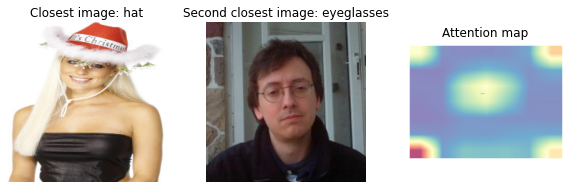

In [51]:
fig, axes = plt.subplots(1, 3, figsize=(10, 8))
axes[0].set(title=f'Closest image: {images_labels[0]}')
axes[0].imshow(image1)
axes[0].axis("off");

axes[1].set(title=f'Second closest image: {images_labels[1]}')
axes[1].imshow(image2)
axes[1].axis("off");

axes[2].set(title=f'Attention map')
axes[2].imshow(attention)
axes[2].axis("off");
plt.subplots_adjust(wspace=0.25, hspace=-0.35)

## Embeddings: get 2D or 3D projection of the embeddings' PCA.

Optionnaly sending custom embedding

In [42]:
data = {"nb_dim": 3}
res = requests.post("http://127.0.0.1:5000/get_embeddings", json=data).json()
res.keys()

dict_keys(['butterfly', 'candle', 'church', 'cup', 'door', 'hat', 'hedgehog', 'helicopter', 'horse', 'pineapple', 'rifle', 'shark', 'snail', 'snake', 'teapot', 'teddy_bear', 'tiger', 'umbrella', 'violin', 'zebra'])

In [43]:
import plotly.graph_objects as go

In [44]:
colors = ["#e6194b","#3cb44b","#ffe119","#4363d8","#f58231","#911eb4","#46f0f0","#f032e6","#bcf60c","#fabebe",
          "#008080","#e6beff","#9a6324","#fffac8","#800000","#aaffc3","#808000","#ffd8b1","#000075","#808080","#000000",
]

In [45]:
traces = []
fig = go.Figure()
for i, (category, coordinates) in enumerate(res.items()):
    trace = go.Scatter(
        x=coordinates['x'],
        y=coordinates['y'],
        name=category,
        mode='markers',
        marker_color=colors[i]
    )
    fig.add_trace(trace)
    fig.update_layout(title='2D plot of the embeddings (projected with the PCA)')
    
fig.show()

In [46]:
traces = []
fig = go.Figure()
for i, (category, coordinates) in enumerate(res.items()):
    trace = go.Scatter3d(
        x=coordinates['x'],
        y=coordinates['y'],
        z=coordinates['z'],
        name=category,
        mode='markers',
        marker=dict(
            size=4,
            color=colors[i],
        )
    )
    fig.add_trace(trace)
    fig.update_layout(title='3D plot of the embeddings (projected with the PCA)')
    
fig.show()

## Dataset: return 5 random images and sketches of a category

In [55]:
data = {"category": "pineapple"}
res = requests.post("http://127.0.0.1:5000/get_dataset_images", json=data).json()

In [56]:
res.keys()

dict_keys(['sketches_0_base64', 'sketches_1_base64', 'sketches_2_base64', 'sketches_3_base64', 'sketches_4_base64', 'images_0_base64', 'images_1_base64', 'images_2_base64', 'images_3_base64', 'images_4_base64'])

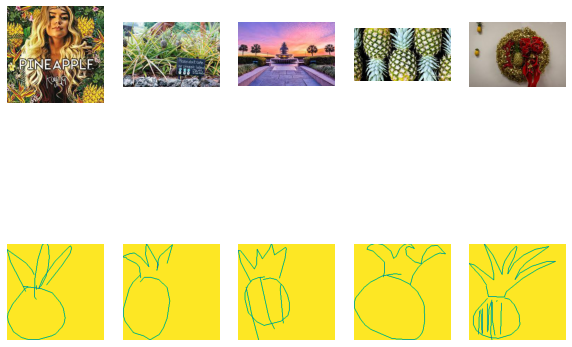

In [58]:
images, sketches = [], []

fig, axes = plt.subplots(2, 5, figsize=(10, 8))
for i in range(5):
    sketch = res[f'sketches_{i}_base64'].split("'")[1]
    image = res[f'images_{i}_base64'].split("'")[1]
    image = base64_to_array(image)
    sketch = base64_to_array(sketch)
    
    axes[0, i].imshow(image)
    axes[0, i].axis("off");
    
    axes[1, i].imshow(sketch)
    axes[1, i].axis("off");